In [3]:
from transmission_data import transmission_function
from wigrad import Wiggler, WigglerRadiationSimulator
import numpy as np
import matplotlib.pyplot as plt
from config_ursse import get_from_config, get_path_from_config
import os
images_dir = os.path.join(get_path_from_config("URSSE_sync_motion_note_dir"),
                          "images")
import valstore as vt

In [5]:
wiggler = Wiggler(K_peak=get_from_config("K_peak"), N_periods=10)
x_max = 0.007257142857142857
y_max = x_max/np.sqrt(2)
n_x = int(512/4)
n_y = int(n_x/np.sqrt(2))
n_l = int(300/4)
l_min = 0.4
l_max = 1.4
x_step = x_max/(n_x-1/2)
y_step = y_max/(n_y-1/2)
l_step = (l_max-l_min)/(n_l-1)
mesh = (np.linspace(x_step/2, x_max, n_x),
        np.linspace(y_step/2, y_max, n_y),
        np.linspace(l_min, l_max, n_l))
spectral_transmission = transmission_function(mesh[2])
wr_sim0 = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=get_from_config("gamma"),
    harmonics=[1,2,3,4,5],
    aperture='ellipse',
#     only_calc_sum_of_both_polarizations=False,  # if False, then both polarizations are calculated separately
    spectral_transmission=spectral_transmission
    )

In [6]:
vt.newval("semiApertureX", 1e3*x_max, "{:.1f}", "mrad",
          "analyzing_collected_data/radiation_spectrum/wigrad_spectrum_calculator.ipynb")
vt.newval("semiApertureY", 1e3*y_max, "{:.1f}", "mrad",
          "analyzing_collected_data/radiation_spectrum/wigrad_spectrum_calculator.ipynb")

In [8]:
wr_sim0.calc_amplitude_on_meshgrid()

In [9]:
wr_sim0.extend_results_using_symmetries()

/opt/homebrew/Caskroom/miniforge/base/envs/env/lib/python3.9/site-packages/wigrad/wigrad.py:209: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


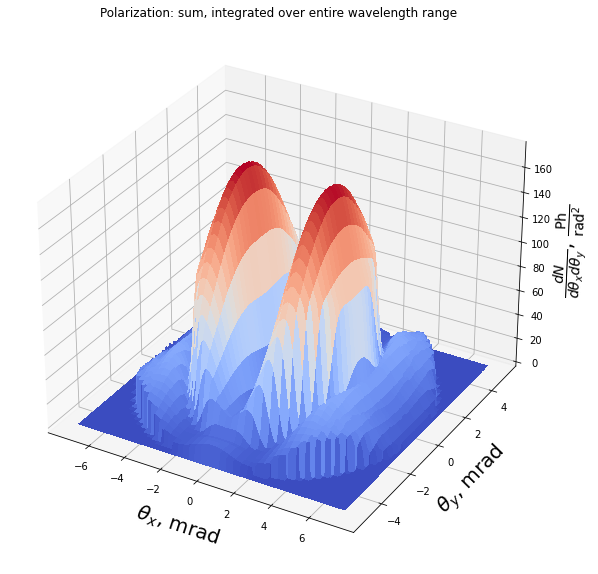

In [10]:
wr_sim0.show_angular_distribution()

In [11]:
# xs = wr_sim0.x_range
# ys = wr_sim0.y_range
# zs = wr_sim0.get_angular_distribution()
# import plotly.graph_objects as go
# fig = go.Figure(data=[go.Surface(z=zs, x=xs, y=ys)])
# fig.update_layout(title='', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90),
#                   scene=dict(aspectratio=dict(x=1, y=1, z=1)))
# fig.show()

In [12]:
wr_sim0.get_total_photon_flux()*7.5e6

44734.50574925412

In [13]:
x_peak = 0.16  # mm
rate_center = 933  # Hz
spad_rad = 0.09 # mm
x_angle_peak = 0.002362129  # rad
spad_rad_angle = x_angle_peak/x_peak*spad_rad
np.sum(wr_sim0.get_angular_distribution()[(wr_sim0.x_2D**2+wr_sim0.y_2D**2) < spad_rad_angle**2])\
    *wr_sim0.x_step*wr_sim0.y_step*2*7.5e6

2682.528595831843

# Calculation of number of emitted photons:

In [15]:
wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=get_from_config("gamma"),
    harmonics=[1,2,3,4,5],
    aperture='ellipse',
#     only_calc_sum_of_both_polarizations=False,  # if False, then both polarizations are calculated separately
    spectral_transmission=None
    )
wr_sim.calc_amplitude_on_meshgrid()
wr_sim.extend_results_using_symmetries()

# Summary:

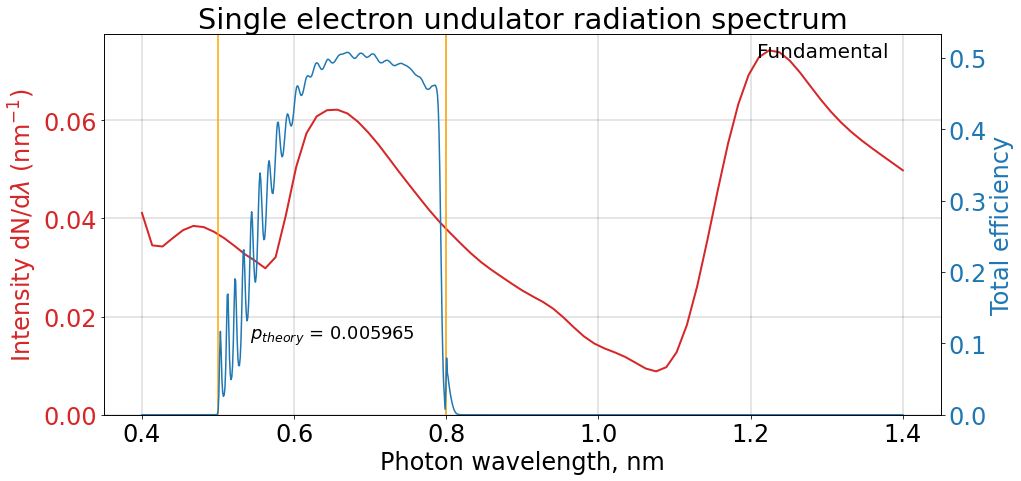

In [16]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
plt.rcParams.update({'font.size': 24,'legend.fontsize':24})
fig,ax = plt.subplots(figsize=[15,7])
ax.set_xlabel('Photon wavelength, nm')
plt.title('Single electron undulator radiation spectrum')
color = 'tab:red'
ax.plot(wr_sim.lambda_range, wr_sim.get_spectral_distribution(), linewidth=2, color = color)
ax.set_ylabel(r'Intensity dN/d$\lambda$ (nm$^{-1}$)', color=color)
plt.tick_params(axis ='y',labelcolor=color) 
ax.grid(color='k', linestyle='-', linewidth=2, alpha=0.1)
l_min = 0.5
l_max = 0.8
plt.axvline(l_min,color='orange')
plt.axvline(l_max,color='orange')
plt.annotate(r'$p_{theory}$ = '+'{:.6f}'.format(wr_sim0.get_total_photon_flux()),
             ((l_min+l_max)/2, 0.2*ax.get_ylim()[1]), ha='center', fontsize=18)
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'Total efficiency', color=color)  # we already handled the x-label with ax1
l_tf = np.linspace(wr_sim.lambda_range[0], wr_sim.lambda_range[-1], 1000)
ax2.plot(l_tf, transmission_function(l_tf), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax.set_ylim(0, ax.get_ylim()[1])
ax2.set_ylim(0, ax2.get_ylim()[1])
align_yaxis(ax, 0, ax2, 0)
plt.text(0.78,0.94,'Fundamental',fontsize=20,transform=ax.transAxes)
plt.show()

In [17]:
0.006*

SyntaxError: invalid syntax (3373569837.py, line 1)

In [18]:
60/100e6

6e-07

In [19]:
5.109e-4/8.725e-5

5.8555873925501425

/var/folders/gy/wdr0lhkn46n55mh2jbgygp500000gn/T/ipykernel_42100/4274172505.py:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax2.pcolormesh(1000*wr_sim0.x_2D, 1000*wr_sim0.y_2D, ang_dist,


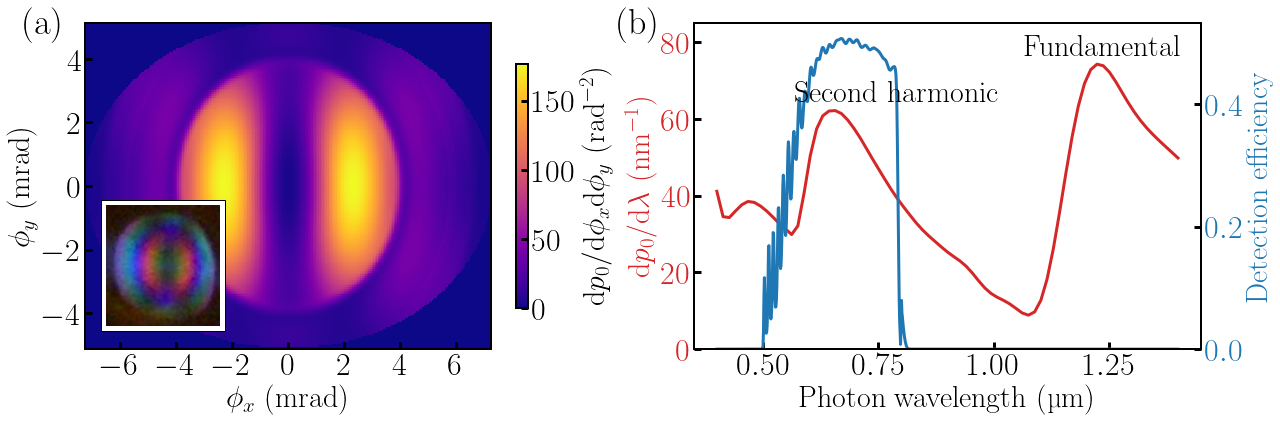

In [32]:
from ursse.path_assistant import get_plot_style_sheet
plt.style.use(get_plot_style_sheet("prab"))

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from mpl_toolkits.mplot3d.axes3d import get_test_data

from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

import matplotlib.image as mpimg

plt.rc('text.latex', preamble=
       r'\usepackage{siunitx}'
      +r'\usepackage{physics}'
       +r'\usepackage{bm}'
      +r'\newcommand{\None}{p_{0}}')



fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(1, 2)
ax2 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1]) #, projection='3d')


ax1.set_xlabel(r'Photon wavelength (\SI{}{\micro m})')
color = 'tab:red'
ax1.plot(wr_sim.lambda_range, 1000*wr_sim.get_spectral_distribution(), color = color, zorder=-100)
ax1.set_ylabel(r'$\dv*{\None}{\lambda}$ $(\SI{}{nm^{-1}})$', color=color)
ax1.tick_params(axis ='y',labelcolor=color) 

l_min = 0.5
l_max = 0.8
# ax1.axvline(l_min,color='orange')
# ax1.axvline(l_max,color='orange')

ax1_ = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax1_.set_ylabel(r'Detection efficiency', color=color)  # we already handled the x-label with ax1
l_tf = np.linspace(wr_sim.lambda_range[0], wr_sim.lambda_range[-1], 1000)
ax1_.plot(l_tf, transmission_function(l_tf), color=color, zorder=-50)
ax1_.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 85)
ax1_.set_ylim(0, ax1_.get_ylim()[1])

ax1_.text(0.65,0.9,'Fundamental',transform=ax1.transAxes)
ax1_.text(0.2,0.76,'Second harmonic',transform=ax1.transAxes)




ang_dist = wr_sim0.get_angular_distribution()

pcm = ax2.pcolormesh(1000*wr_sim0.x_2D, 1000*wr_sim0.y_2D, ang_dist,
                     cmap=cm.get_cmap('plasma'))
# asp = (ax2.get_ylim()[1]-ax2.get_ylim()[0])/(ax2.get_xlim()[1]-ax2.get_xlim()[0])
# ax2.set_aspect(1/np.sqrt(2)*1/asp)
ax2.set_xlabel(r'$\phi_x$ $(\SI{}{mrad})$')
ax2.set_ylabel(r'$\phi_y$ $(\SI{}{mrad})$')
ax2.set_yticks(ticks=np.arange(-4,6,2))
ax2.set_xticks(ticks=np.arange(-6,8,2))

cb = fig.colorbar(pcm, ax=ax2, shrink=0.75,
                  label=r"$\dd\None/\dd\phi_x\dd\phi_y$ $(\SI{}{rad^{-2}})$",
                 ticks=[0,50,100,150])


imagebox = OffsetImage(mpimg.imread('photo.png'), zoom=0.6)

ab = AnnotationBbox(imagebox, (-6.5, -4.4),
                   box_alignment=(0,0),
                   pad=0.2)

ax2.add_artist(ab)


for ax, lab in zip((ax2, ax1), ["(a)", "(b)"]):
    ax.text(-0.15, 1.05, lab, transform=ax.transAxes, va='top', ha='left',
           fontsize=36)
    
fig.savefig(os.path.join(images_dir,
                             "spectral_angular_properties.png"),
            dpi=300, bbox_inches='tight')

plt.show()

In [15]:
vt.newval("pTheor", wr_sim0.get_total_photon_flux(), "{:.2e}", "",
          "analyzing_collected_data/radiation_spectrum/wigrad_spectrum_calculator.ipynb")

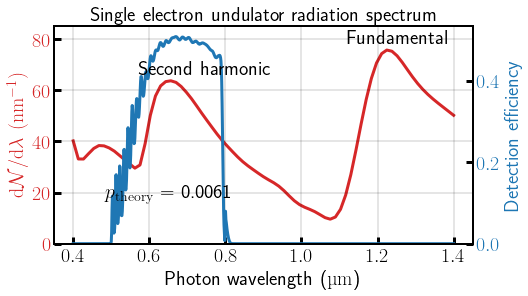

In [23]:
fig, ax1 = plt.subplots(figsize=(7.5,4))



ax1.set_xlabel(r'Photon wavelength (\SI{}{\micro m})')
color = 'tab:red'
ax1.plot(wr_sim.lambda_range, 1000*wr_sim.get_spectral_distribution(), color = color, zorder=-100)
ax1.set_ylabel(r'$\dv*{\mathcal{N}}{\lambda}$ $(\SI{}{nm^{-1}})$', color=color)
ax1.tick_params(axis ='y',labelcolor=color) 

l_min = 0.5
l_max = 0.8
# ax1.axvline(l_min,color='orange')
# ax1.axvline(l_max,color='orange')

ax1_ = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax1_.set_ylabel(r'Detection efficiency', color=color)  # we already handled the x-label with ax1
l_tf = np.linspace(wr_sim.lambda_range[0], wr_sim.lambda_range[-1], 1000)
ax1_.plot(l_tf, transmission_function(l_tf), color=color, zorder=-50)
ax1_.tick_params(axis='y', labelcolor=color)
p_th = wr_sim0.get_total_photon_flux()
ax1_.annotate(r'$p_{\mathrm{theory}}$ = '+'{:.4f}'.format(p_th),
             ((l_min+l_max)/2, 0.2*ax1_.get_ylim()[1]), ha='center', zorder=100)
ax1.grid(color='k', linestyle='-', linewidth=2, alpha=0.1)
ax1.set_ylim(0, 85)
ax1_.set_ylim(0, ax1_.get_ylim()[1])

ax1_.text(0.7,0.92,'Fundamental',transform=ax1.transAxes)
ax1_.text(0.2,0.78,'Second harmonic',transform=ax1.transAxes)
ax1.set_title("Single electron undulator radiation spectrum")

fig.savefig(os.path.join(images_dir,
                             "spectral_properties.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [21]:
p_th*7.5e6

45538.726729651265

In [2]:
f"{1e-9/1.6e-19:.2e}"

'6.25e+09'

In [3]:
1e-9/133e-9

0.007518796992481203

In [7]:
3.5e-3*133e-9

4.6550000000000005e-10